# Finetune VGG16


With 1000 x 400 melspectrogram images without data augmentation


In [1]:
import sys
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
import time

In [2]:
# Get the absolute path to the project root without relying on __file__
notebook_path = os.getcwd()  # Gets current working directory
project_root = os.path.abspath(os.path.join(notebook_path, "../.."))
sys.path.insert(0, project_root)

In [3]:
print(torch.__version__)
print(torch.cuda.is_available())

2.5.1+cu121
True


Set the seed for reproducability


In [4]:
random_seed = 42

torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

if (torch.cuda.is_available()):
    torch.cuda.manual_seed(random_seed)

Set some constant strings


In [5]:
FINETUNED_MODEL = 'vgg16'

train_csv = '../../../data/melspectrogram_train_dataset.csv'
test_csv = '../../../data/melspectrogram_test_dataset.csv'
val_csv = '../../../data/melspectrogram_val_dataset.csv'
root_dir = '../../../data/'
class_weights_path = '../../../data/class_weights.pt'

Custom dataset class for loading the mel spectrogram images


In [6]:
from datasets.MelspectrogramDataset import MelSpectrogramDataset

Define the training function


In [7]:
def train(model, trainloader, criterion, optimizer, device):
    train_loss = 0.0
    train_total = 0
    train_correct = 0

    # train mode
    model.train()

    epoch_start = time.time()
    pbar = tqdm(enumerate(trainloader), total=len(
        trainloader), desc="Training")

    for i, (inputs, labels) in pbar:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Update training loss
        train_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

        # Calculate time metrics
        elapsed = time.time() - epoch_start
        progress = (i + 1) / len(trainloader)
        eta = elapsed / progress - elapsed

        # Update progress bar with current loss and ETA
        pbar.set_postfix({
            "Loss": f"{loss.item()}",
            "Elapsed": f"{elapsed:.4f}s",
            "ETA": f"{eta:.4f}s"
        })

    train_loss = train_loss / len(trainloader)
    train_accuracy = train_correct / train_total * 100

    return model, train_loss, train_accuracy

Define the validation function


In [8]:
def validate(model, valloader, criterion, device):
    val_loss = 0.0
    val_total = 0
    val_correct = 0

    # Switch to evaluation mode
    model.eval()

    epoch_start = time.time()
    pbar = tqdm(enumerate(valloader), total=len(
        valloader), desc="Validating")

    with torch.no_grad():
        for i, (inputs, labels) in pbar:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Update test loss
            val_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

            # Calculate time metrics
            elapsed = time.time() - epoch_start
            progress = (i + 1) / len(valloader)
            eta = elapsed / progress - elapsed

            # Update progress bar with current loss and ETA
            pbar.set_postfix({
                "Loss": f"{loss.item()}",
                "Elapsed": f"{elapsed:.4f}s",
                "ETA": f"{eta:.4f}s"
            })

    val_loss = val_loss / len(valloader)
    val_accuracy = val_correct / val_total * 100

    return val_loss, val_accuracy

Define what happens in each epoch


In [9]:
def train_epochs(model, trainloader, valloader, criterion, optimizer, device, num_epochs):
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    best_accuracy = 0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        epoch_start = time.time()

        model, train_loss, train_accuracy = train(
            model, trainloader, criterion, optimizer, device)
        val_loss, val_accuracy = validate(
            model, valloader, criterion, device)

        epoch_elapsed = time.time() - epoch_start
        print(f"Epoch {epoch+1} completed in {epoch_elapsed:.4f}s")
        print(f'Train Loss: {train_loss} - Train Accuracy: {train_accuracy}')
        print(
            f'Validation Loss: {val_loss} - Validation Accuracy: {val_accuracy}')
        print()

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # Check if current model is best performing using test_accuracy
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            torch.save(model.state_dict(), f'best_{FINETUNED_MODEL}.pt')
            checkpoint = {
                'epoch': epoch + 1,
                'train_losses': train_losses,
                'train_accuracies': train_accuracies,
                'val_losses': val_losses,
                'val_accuracies': val_accuracies,
            }
            torch.save(checkpoint, f'best_{FINETUNED_MODEL}_checkpoint.pt')

    return model, train_losses, train_accuracies, val_losses, val_accuracies

Plot the loss and accuracy graphs


In [10]:
def plot_loss(train_losses, val_losses):
    plt.figure()
    plt.plot(range(len(train_losses)), train_losses, label='Training Loss')
    plt.plot(range(len(val_losses)), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [11]:
def plot_accuracy(train_accuracies, val_accuracies):
    plt.figure()
    plt.plot(range(len(train_accuracies)),
             train_accuracies, label='Training Accuracy')
    plt.plot(range(len(val_accuracies)),
             val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

Define the model


In [12]:
model = models.vgg16(pretrained=True)

c:\Users\profi\OneDrive\Desktop\AI-Project--Speech-Emotion-Recognition\myenv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\profi\OneDrive\Desktop\AI-Project--Speech-Emotion-Recognition\myenv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Prepare for fine-tuning


In [13]:
# Number of classes
num_classes = 9

# Freeze all layers except the last fully connected layer
for param in model.parameters():
    param.requires_grad = False  # Freeze all layers

# Modify final fully connected layer according to number of classes
num_features = model.classifier[-1].in_features
model.classifier[-1] = nn.Linear(num_features, num_classes)
# print("Modified model")
# print(model)

# Unfreeze the final fully connected layer so it will be trained
for param in model.classifier[-1].parameters():
    param.requires_grad = True

# Move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Define the learning rate, criterion, optimizer, transformations, and number of epochs


In [14]:
learning_rate = 0.001

class_weights = torch.load(class_weights_path).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Define transformations
transform = transforms.Compose([
    # Resize the Mel spectrogram to 224x224, suitable for VGG16
    transforms.Resize((224, 224)),
    transforms.ToTensor(),          # Convert to Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[
                         0.229, 0.224, 0.225])  # Normalize to ImageNet stats
])

epochs = 20

C:\Users\profi\AppData\Local\Temp\ipykernel_14772\1689401030.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  class_weights = torch.load(class_weights_path).to(device)


Execute the fine-tuning


Mapping from Emotion to Number: {'Anger': 0, 'Bored': 1, 'Disgust': 2, 'Fear': 3, 'Happy': 4, 'Neutral': 5, 'Question': 6, 'Sad': 7, 'Surprise': 8}
Model is on: cuda:0
Epoch 1/20


Validating: 100%|██████████| 75/75 [00:15<00:00,  4.69it/s, Loss=1.710886836051941, Elapsed=27.6402s, ETA=0.0000s]   


Epoch 1 completed in 108.2963s
Train Loss: 1.4616046348059109 - Train Accuracy: 40.17774360597906
Validation Loss: 1.270481564203898 - Validation Accuracy: 45.77880962431406

Epoch 2/20


Validating: 100%|██████████| 75/75 [00:15<00:00,  4.74it/s, Loss=1.3680485486984253, Elapsed=27.1589s, ETA=0.0000s] 


Epoch 2 completed in 106.0191s
Train Loss: 1.3616503759615683 - Train Accuracy: 43.196671264783696
Validation Loss: 1.2390605401992798 - Validation Accuracy: 48.237653018151114

Epoch 3/20


Validating: 100%|██████████| 75/75 [00:15<00:00,  4.78it/s, Loss=1.5980982780456543, Elapsed=26.9085s, ETA=0.0000s] 


Epoch 3 completed in 105.9418s
Train Loss: 1.342017932089767 - Train Accuracy: 43.963275366907126
Validation Loss: 1.2048560285568237 - Validation Accuracy: 50.970873786407765

Epoch 4/20


Validating: 100%|██████████| 75/75 [00:15<00:00,  4.75it/s, Loss=1.4471555948257446, Elapsed=27.7207s, ETA=0.0000s]  


Epoch 4 completed in 106.1643s
Train Loss: 1.333094288848039 - Train Accuracy: 44.587413219963366
Validation Loss: 1.198666534423828 - Validation Accuracy: 47.551709582102156

Epoch 5/20


Validating: 100%|██████████| 75/75 [00:15<00:00,  4.72it/s, Loss=1.5475950241088867, Elapsed=27.0464s, ETA=0.0000s] 


Epoch 5 completed in 105.9963s
Train Loss: 1.3280293338560645 - Train Accuracy: 44.512788041880555
Validation Loss: 1.2258816146850586 - Validation Accuracy: 47.5833685099198

Epoch 6/20


Validating: 100%|██████████| 75/75 [00:15<00:00,  4.76it/s, Loss=1.4798191785812378, Elapsed=26.7116s, ETA=0.0000s] 


Epoch 6 completed in 105.7822s
Train Loss: 1.3321150637775487 - Train Accuracy: 44.65525429094774
Validation Loss: 1.1945882360140483 - Validation Accuracy: 46.232587589700294

Epoch 7/20


Validating: 100%|██████████| 75/75 [00:15<00:00,  4.73it/s, Loss=1.481958270072937, Elapsed=26.9655s, ETA=0.0000s]  


Epoch 7 completed in 106.1331s
Train Loss: 1.326650940269404 - Train Accuracy: 44.97863006263992
Validation Loss: 1.2058213257789612 - Validation Accuracy: 49.609539890249046

Epoch 8/20


Validating: 100%|██████████| 75/75 [00:15<00:00,  4.72it/s, Loss=1.601296305656433, Elapsed=27.0167s, ETA=0.0000s]  


Epoch 8 completed in 105.7791s
Train Loss: 1.3174870269146959 - Train Accuracy: 45.2839148820696
Validation Loss: 1.1939213959376018 - Validation Accuracy: 46.86576614605319

Epoch 9/20


Validating: 100%|██████████| 75/75 [00:15<00:00,  4.72it/s, Loss=1.4529664516448975, Elapsed=26.8572s, ETA=0.0000s] 


Epoch 9 completed in 105.8132s
Train Loss: 1.320813883935785 - Train Accuracy: 44.87912982519617
Validation Loss: 1.1702569325764973 - Validation Accuracy: 51.48796960742929

Epoch 10/20


Validating: 100%|██████████| 75/75 [00:15<00:00,  4.76it/s, Loss=1.6420462131500244, Elapsed=26.8847s, ETA=0.0000s] 


Epoch 10 completed in 105.7823s
Train Loss: 1.3166673462514933 - Train Accuracy: 45.304267203364915
Validation Loss: 1.192019007205963 - Validation Accuracy: 50.87589700295483

Epoch 11/20


Validating: 100%|██████████| 75/75 [00:15<00:00,  4.72it/s, Loss=1.7374403476715088, Elapsed=26.9533s, ETA=0.0000s] 


Epoch 11 completed in 105.8612s
Train Loss: 1.3209876104586387 - Train Accuracy: 44.88139119422899
Validation Loss: 1.1865482544898986 - Validation Accuracy: 51.825664837484176

Epoch 12/20


Validating: 100%|██████████| 75/75 [00:15<00:00,  4.81it/s, Loss=1.3982549905776978, Elapsed=26.7079s, ETA=0.0000s] 


Epoch 12 completed in 105.3657s
Train Loss: 1.3203738676330257 - Train Accuracy: 45.10978946654304
Validation Loss: 1.190924444993337 - Validation Accuracy: 47.38286196707471

Epoch 13/20


Validating: 100%|██████████| 75/75 [00:15<00:00,  4.77it/s, Loss=1.2312421798706055, Elapsed=26.8261s, ETA=0.0000s] 


Epoch 13 completed in 105.9016s
Train Loss: 1.316184563271572 - Train Accuracy: 45.166323692363356
Validation Loss: 1.1619996778170267 - Validation Accuracy: 47.720557197129594

Epoch 14/20


Validating: 100%|██████████| 75/75 [00:15<00:00,  4.76it/s, Loss=1.4158425331115723, Elapsed=26.7921s, ETA=0.0000s] 


Epoch 14 completed in 105.8533s
Train Loss: 1.316659398850678 - Train Accuracy: 45.20702833495398
Validation Loss: 1.1828765193621318 - Validation Accuracy: 50.02110595187843

Epoch 15/20


Validating: 100%|██████████| 75/75 [00:15<00:00,  4.72it/s, Loss=1.2604243755340576, Elapsed=26.9654s, ETA=0.0000s] 


Epoch 15 completed in 105.9414s
Train Loss: 1.3184758741731588 - Train Accuracy: 45.06908482395242
Validation Loss: 1.1740968863169352 - Validation Accuracy: 47.61502743773744

Epoch 16/20


Validating: 100%|██████████| 75/75 [00:15<00:00,  4.75it/s, Loss=1.4309982061386108, Elapsed=26.8108s, ETA=0.0000s] 


Epoch 16 completed in 105.4813s
Train Loss: 1.3264292433771785 - Train Accuracy: 44.976368693607114
Validation Loss: 1.175933051109314 - Validation Accuracy: 49.97889404812157

Epoch 17/20


Validating: 100%|██████████| 75/75 [00:15<00:00,  4.76it/s, Loss=1.2943294048309326, Elapsed=26.9590s, ETA=0.0000s] 


Epoch 17 completed in 105.9623s
Train Loss: 1.3183188906983834 - Train Accuracy: 45.136925894936795
Validation Loss: 1.162271953423818 - Validation Accuracy: 47.87885183621781

Epoch 18/20


Validating: 100%|██████████| 75/75 [00:15<00:00,  4.75it/s, Loss=1.3749980926513672, Elapsed=26.8571s, ETA=0.0000s] 


Epoch 18 completed in 105.7458s
Train Loss: 1.3044717048289458 - Train Accuracy: 45.6819158318446
Validation Loss: 1.1746000202496847 - Validation Accuracy: 50.94976783452934

Epoch 19/20


Validating: 100%|██████████| 75/75 [00:15<00:00,  4.77it/s, Loss=1.6129156351089478, Elapsed=26.8083s, ETA=0.0000s] 


Epoch 19 completed in 105.9093s
Train Loss: 1.3209960707005737 - Train Accuracy: 45.1391872639696
Validation Loss: 1.209777642885844 - Validation Accuracy: 50.08442380751372

Epoch 20/20


Validating: 100%|██████████| 75/75 [00:15<00:00,  4.77it/s, Loss=1.1831153631210327, Elapsed=26.9839s, ETA=0.0000s] 


Epoch 20 completed in 106.2697s
Train Loss: 1.323698426257668 - Train Accuracy: 44.915311729721175
Validation Loss: 1.154017407099406 - Validation Accuracy: 49.75728155339806



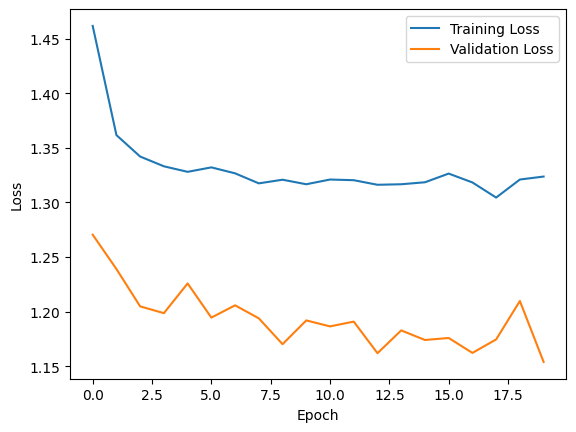

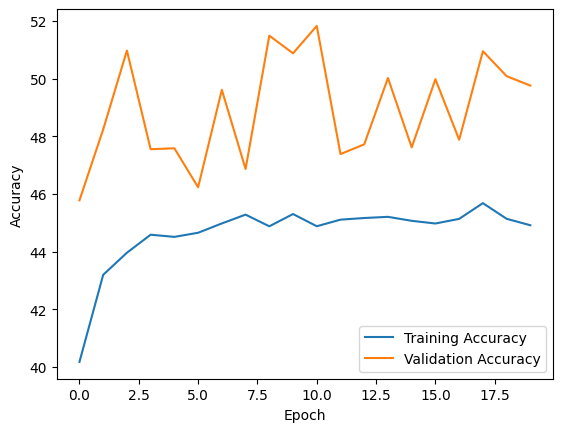

In [15]:
trainset = MelSpectrogramDataset(
    csv_file=train_csv, root_dir=root_dir, transform=transform)
valset = MelSpectrogramDataset(
    csv_file=val_csv, root_dir=root_dir, transform=transform)
testset = MelSpectrogramDataset(
    csv_file=test_csv, root_dir=root_dir, transform=transform)

trainloader = DataLoader(trainset, batch_size=128,
                         shuffle=True, num_workers=8, pin_memory=True)
valloader = DataLoader(valset, batch_size=128,
                       shuffle=False, num_workers=8, pin_memory=True)
testloader = DataLoader(testset, batch_size=128,
                        shuffle=False, num_workers=8, pin_memory=True)

# Label mappings
labelmap = trainset.label_map
print(f"Mapping from Emotion to Number: {labelmap}")

print(f"Model is on: {next(model.parameters()).device}")
model, train_losses, train_accuracies, val_losses, val_accuracies = train_epochs(
    model, trainloader, valloader, criterion, optimizer, device, epochs)
torch.save(model.state_dict(), f'{FINETUNED_MODEL}_variables_{epochs}.pt')

# Plots
plot_loss(train_losses, val_losses)
plot_accuracy(train_accuracies, val_accuracies)

Define the function to plot the confusion matrix


In [16]:
import seaborn as sns
from sklearn.metrics import confusion_matrix


def plot_confusion_matrix(y_true, y_pred):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Create figure and axes
    plt.figure(figsize=(10, 8))

    # Create heatmap
    sns.heatmap(cm,
                annot=True,  # Show numbers in cells
                fmt='d',     # Use integer formatting
                cmap='Blues',  # Color scheme
                xticklabels=trainset.label_map.keys(),
                yticklabels=trainset.label_map.keys())

    # Set labels and title
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix')

    # Rotate axis labels for better readability
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)

    plt.tight_layout()
    plt.show()

Define the function to evaluate best model on test set


In [17]:
def get_predictions(model, testloader, device, model_path):
    # Load the best model weights
    model.load_state_dict(torch.load(model_path))
    model.eval()

    all_preds = []
    all_labels = []
    print("Evaluating best model on test set...")

    with torch.no_grad():
        for inputs, labels in tqdm(testloader, desc='Testing'):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            # Store predictions for confusion matrix
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_preds, all_labels

Define the function to print out the evaluation metrics


In [18]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report


def get_evaluation_metrics(true_labels, pred_labels, label_map):
    # Compute metrics
    accuracy = accuracy_score(true_labels, pred_labels)
    precision, recall, f1, _ = precision_recall_fscore_support(
        true_labels, pred_labels, average='weighted')

    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Test Precision: {precision:.4f}")
    print(f"Test Recall: {recall:.4f}")
    print(f"Test F1-score: {f1:.4f}\n")

    # Print detailed classification report
    print(classification_report(true_labels, pred_labels,
          target_names=list(label_map.keys())))

Evaluate the best model on the test set


C:\Users\profi\AppData\Local\Temp\ipykernel_14772\3256607076.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Evaluating best model on test set...


Testing: 100%|██████████| 75/75 [00:28<00:00,  2.64it/s]

Test Accuracy: 0.5120
Test Precision: 0.5668
Test Recall: 0.5120
Test F1-score: 0.5065

              precision    recall  f1-score   support

       Anger       0.42      0.61      0.49       916
       Bored       0.68      0.71      0.70      1098
     Disgust       0.25      0.69      0.37       291
        Fear       0.26      0.63      0.37       308
       Happy       0.72      0.24      0.36      1914
     Neutral       0.53      0.46      0.49      2226
    Question       0.58      0.70      0.64      1139
         Sad       0.54      0.50      0.52       857
    Surprise       0.57      0.56      0.57       728

    accuracy                           0.51      9477
   macro avg       0.51      0.57      0.50      9477
weighted avg       0.57      0.51      0.51      9477



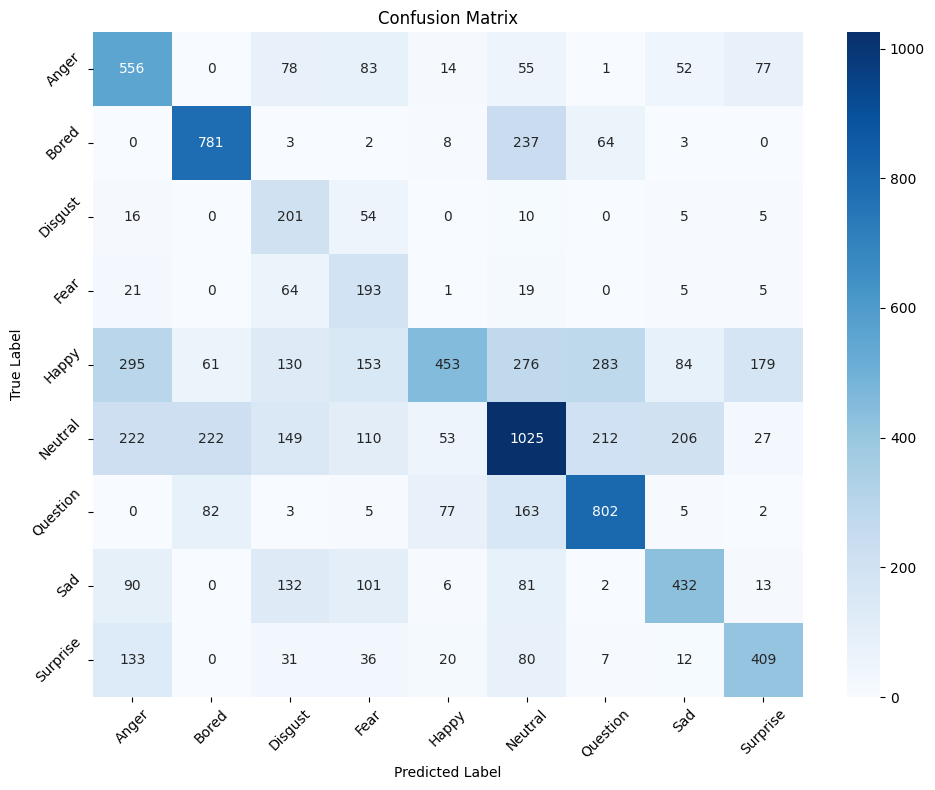

In [19]:
# Load and get predictions from the bets model
best_model_path = f'best_{FINETUNED_MODEL}.pt'
all_preds, all_labels = get_predictions(
    model=model,
    testloader=testloader,
    device=device,
    model_path=best_model_path
)

# Print detailed evaluation metrics
get_evaluation_metrics(all_labels, all_preds, labelmap)

# Plot confusion matrix
plot_confusion_matrix(all_labels, all_preds)